# Import Packages

In [ ]:

import torch
from torchsummary import summary
import torchvision # This library is used for image-based operations (Augmentations)
import os
import gc
from tqdm import tqdm
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
import glob
import wandb
import matplotlib.pyplot as plt
import math
import torch.nn.functional as F
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", DEVICE)

# Kaggle Setup

In [4]:
!pip install --upgrade --force-reinstall --no-deps kaggle==1.5.8
!mkdir /root/.kaggle

with open("/root/.kaggle/kaggle.json", "w+") as f:
    f.write('{"username":"xiaocmumsppm", "key":"6a25da7cd718a7252a65bb3a7658930a"}')
    # Put your kaggle username & key here

!chmod 600 /root/.kaggle/kaggle.json

!mkdir '/root/autodl-tmp/data'

!kaggle competitions download -c 11785-hw2p2-face-recognition
!unzip -qo '/root/autodl-tmp/11785-hw2p2-face-recognition.zip' -d '/root/autodl-tmp'

!kaggle competitions download -c 11785-hw2p2-face-verification
!unzip -qo '/root/autodl-tmp/11785-hw2p2-face-verification.zip' -d '/root/autodl-tmp'

In [2]:
!nvidia-smi # Run this to see what GPU you have

Wed Mar 13 07:55:05 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.146.02             Driver Version: 535.146.02   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4090        On  | 00000000:16:00.0 Off |                  Off |
| 30%   27C    P8              15W / 450W |      3MiB / 24564MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
config = {
    'batch_size': 256, # Increase this if your GPU can handle it
    'lr': 1e-3,
    'epochs': 150, # 20 epochs is recommended ONLY for the early submission - you will have to train for much longer typically.
    # Include other parameters as needed.
}

# Data Preprocess
I applied several image enhancement metheds: Random Horizontal flip, random perspective, random affine, color jitter, and normalization. But in fact, I think these methods did not have so much impact on the outcome.
It's pretty interesting to notice that the training process on my server which consists of 8 RTX 4090 gpus and a 128 cores cpu, the validation proess is much more slower than training on my PC with a 3080 ti gpu with a 64 core i9 -12th cpu. Though training part is faster, but when it comes to validation part, the speed is sooooo low. It even takes 6 more times of time than the training.(Each train epoch only takes one miniute while validation takes at least 6 miniutes.) However, it only takes around 30 seconds to validate the model on my PC. I decreased the num of worker and batch size for the validation and testing, however it got worse. Thus, I think it was not a capacity problem. After I increased the num of workers and batch size, things getting better. This really confused me a lot and now I still don't know why.

In [3]:
# --------------------------------------------------- #

# Data paths

DATA_DIR    = "/root/autodl-tmp/11-785-s24-hw2p2-classification" # TODO: Path where you have downloaded the classificaation data
TRAIN_DIR   = os.path.join(DATA_DIR, "train")
VAL_DIR     = os.path.join(DATA_DIR, "dev")
TEST_DIR    = os.path.join(DATA_DIR, "test")

# --------------------------------------------------- #

# Transformations/augmentations of the Train dataset

"""
Refer https://pytorch.org/vision/stable/transforms.html
Implementing the right train transforms/augmentation methods is key to improving performance.
Most torchvision transforms are done on PIL images. So you convert it into a tensor at the end with ToTensor()
But there are some transforms which are performed after ToTensor() : e.g - Normalization
#Normalization Tip - Do not blindly use normalization that is not suitable for this dataset
"""

train_transforms = torchvision.transforms.Compose([

    torchvision.transforms.RandomHorizontalFlip(p = 0.5),
    torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), 
    torchvision.transforms.RandomPerspective(distortion_scale=0.2, p=0.5, interpolation=3),
    torchvision.transforms.RandomAffine(degrees=(-10, 10), translate=(0.1, 0.1), scale=(0.9, 1.1)), 

    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.5103, 0.4014, 0.3508], std=[0.3077, 0.2701, 0.2591])
    ])

# --------------------------------------------------- #

# Transformations/augmentations of the Val dataset

"""
You should NOT have data augmentation on the validation set. Why?
Because it is not reasonable to change the validation. We need to test model based on true input.
And we are trying to learn patterns rather than the strengthen pattern.
"""

valid_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.5103, 0.4014, 0.3508], std=[0.3077, 0.2701, 0.2591])
    ])

# --------------------------------------------------- #

# Initializing the train and val datasets

train_dataset   = torchvision.datasets.ImageFolder(TRAIN_DIR, transform = train_transforms)
valid_dataset   = torchvision.datasets.ImageFolder(VAL_DIR, transform = valid_transforms)

# --------------------------------------------------- #

# Initializing the train and val dataloaders

train_loader = torch.utils.data.DataLoader(dataset       = train_dataset,
                                           batch_size    = config['batch_size'],
                                           shuffle        = True,
                                           num_workers = 8, # Uncomment this line if you want to increase your num workers
                                           pin_memory = True
                                           )

valid_loader = torch.utils.data.DataLoader(dataset       = valid_dataset,
                                           batch_size    = 1024,
                                           shuffle        = False,
                                           num_workers = 128, # Uncomment this line if you want to increase your num workers
                                           )

In [4]:
# --------------------------------------------------- #

# Test dataset class

"""
You can do this with ImageFolder as well, but it requires some tweaking
"""

class TestDataset(torch.utils.data.Dataset):

    def __init__(self, data_dir, transforms):
        self.data_dir   = data_dir
        self.transforms = transforms

        # This one-liner basically generates a sorted list of full paths to each image in the test directory
        self.img_paths  = list(map(lambda fname: os.path.join(self.data_dir, fname), sorted(os.listdir(self.data_dir))))

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        return self.transforms(Image.open(self.img_paths[idx]))

# --------------------------------------------------- #

# Initializing the test dataset

"""
Why are we using val_transforms for Test Data?
"""

test_dataset = TestDataset(TEST_DIR, transforms = valid_transforms)

# --------------------------------------------------- #

# Initializing the test dataloader

test_loader = torch.utils.data.DataLoader(dataset    = test_dataset,
                                          batch_size = 1024,
                                          shuffle     = False,
                                          drop_last  = False,
                                          num_workers = 128,
                                          # Uncomment this line if you want to increase your num workers
                                          )

In [5]:
print("Number of classes    : ", len(train_dataset.classes))
print("No. of train images  : ", train_dataset.__len__())
print("Shape of image       : ", train_dataset[0][0].shape)
print("Batch size           : ", config['batch_size'])
print("Train batches        : ", train_loader.__len__())
print("Val batches          : ", valid_loader.__len__())

Number of classes    :  7001
No. of train images  :  140020
Shape of image       :  torch.Size([3, 224, 224])
Batch size           :  256
Train batches        :  547
Val batches          :  35


# Model Defintion
I choose Convnext here. I refered the official document of ConvNext: https://github.com/facebookresearch/ConvNeXt

ConvNeXt is a net that use the design of transformer. It performes significant better than traditional CNNs.
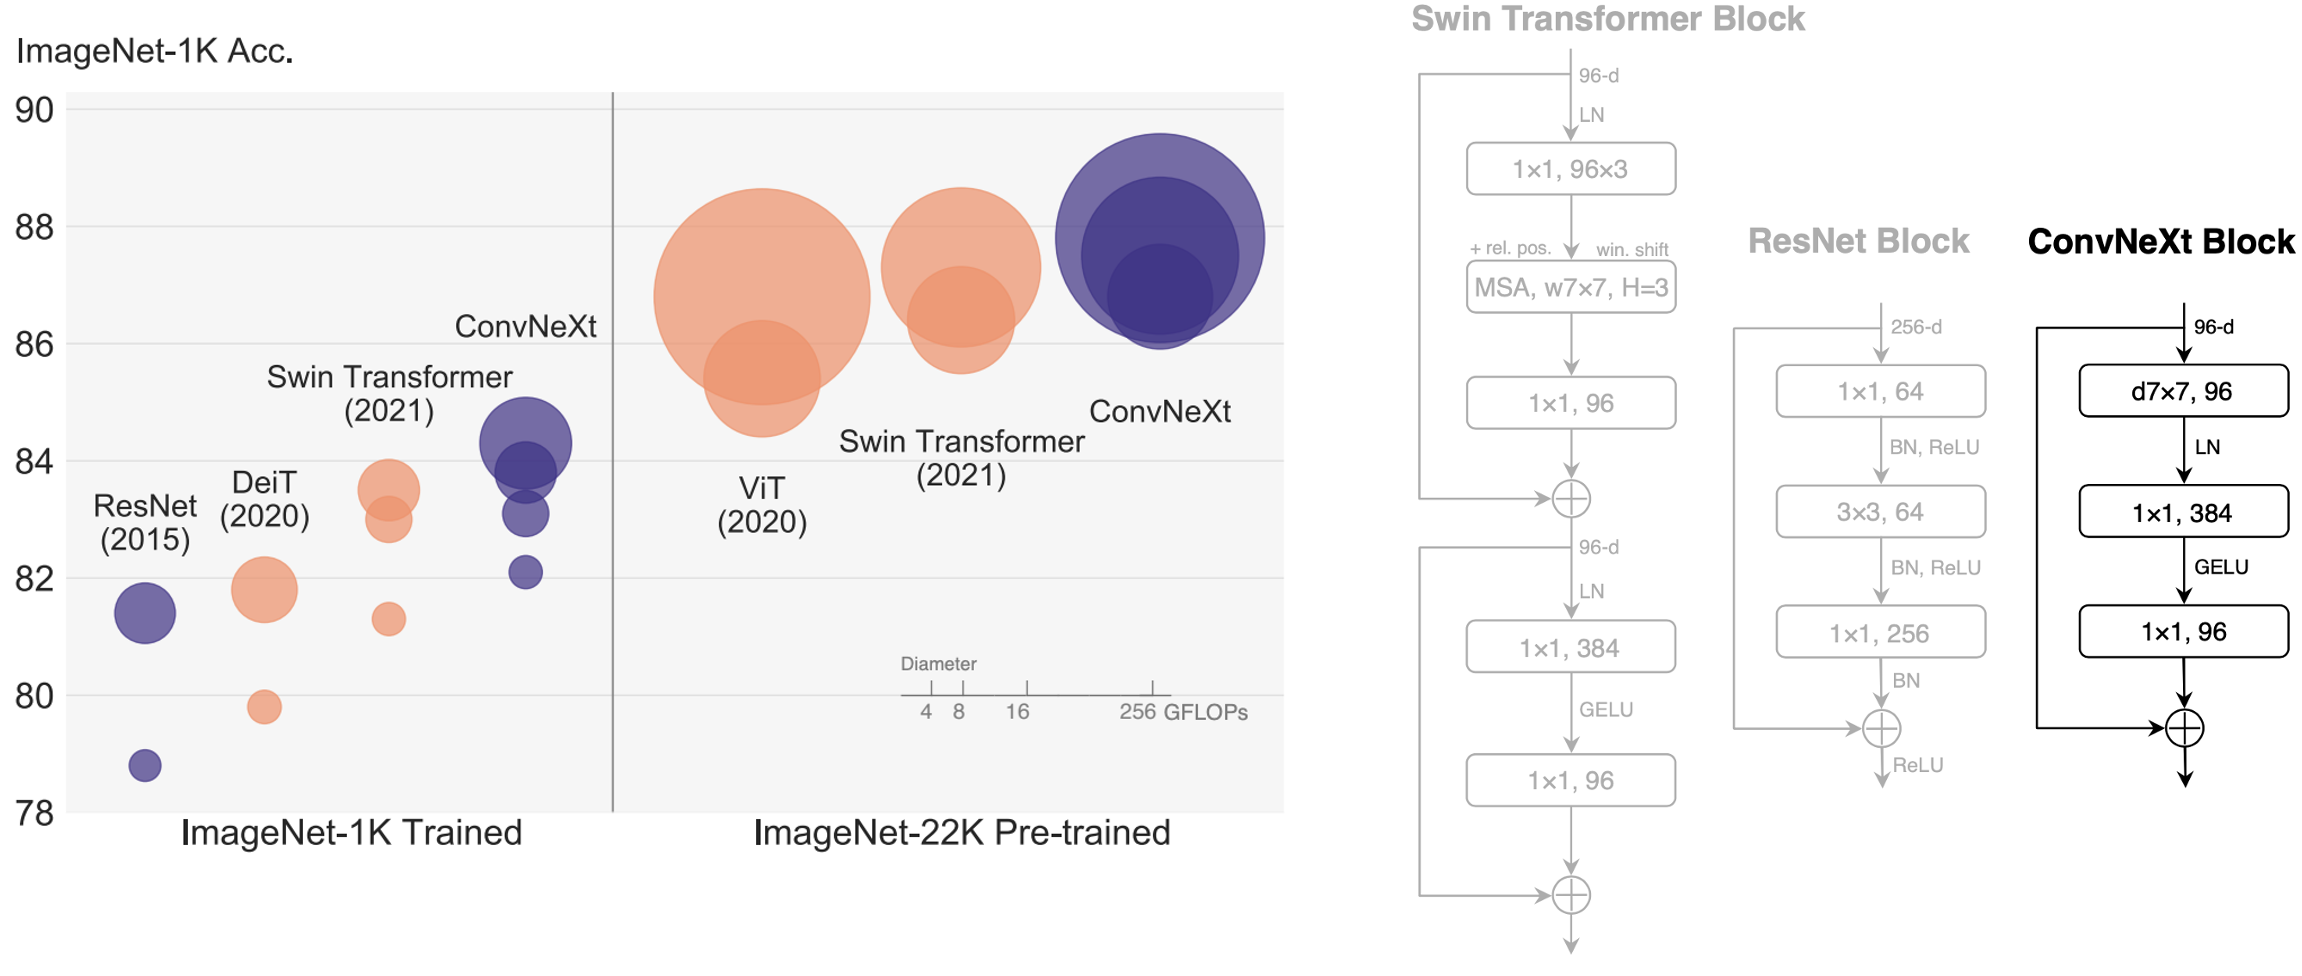

In fact, ConvNeXt is the only one net I ued to achieve medium cutoff (83%) without any additional regularization, which is incredible! I adjusted the structure of the original ConvNeXt to satisfy the parameter num limitaion. This could probably lead to some loss but I did not do experience on that. 

Here's the strucure I tried:
ResNet18, ResNet18 with SE module, ResNet18 with CARM module, Efficient Net, Dense Net, GhostFaceNet, ShuffleNet

ConvNext does not use new method or innovated structures. The key idea is to keep useful design of transformer. 

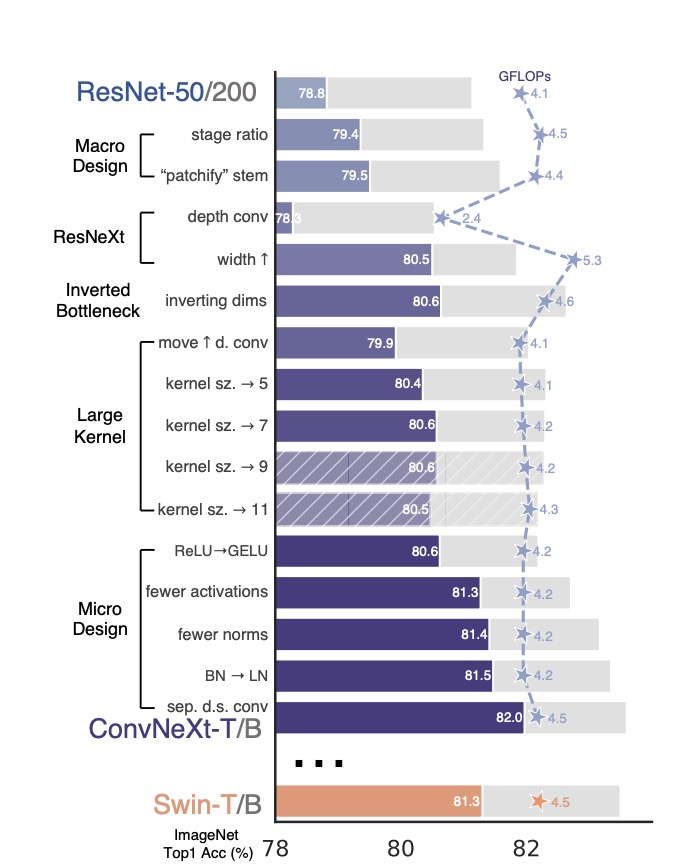

This figure shows the process of convNext Design. We can see there are not any new features.


In [6]:
class LayerNorm(torch.nn.Module):
    """ 
    LayerNorm that supports two data formats: channels_last (default) or channels_first. 
    The ordering of the dimensions in the inputs. channels_last corresponds to inputs with 
    shape (batch_size, height, width, channels) while channels_first corresponds to inputs 
    with shape (batch_size, channels, height, width).
    """
    def __init__(self, normalized_shape, eps=1e-6, data_format="channels_last"):
        super().__init__()
        self.weight = torch.nn.Parameter(torch.ones(normalized_shape))
        self.bias = torch.nn.Parameter(torch.zeros(normalized_shape))
        self.eps = eps
        self.data_format = data_format
        if self.data_format not in ["channels_last", "channels_first"]:
            raise NotImplementedError 
        self.normalized_shape = (normalized_shape, )
    
    def forward(self, x):
        if self.data_format == "channels_last":
            return F.layer_norm(x, self.normalized_shape, self.weight, self.bias, self.eps)
        elif self.data_format == "channels_first":
            u = x.mean(1, keepdim=True)
            s = (x - u).pow(2).mean(1, keepdim=True)
            x = (x - u) / torch.sqrt(s + self.eps)
            x = self.weight[:, None, None] * x + self.bias[:, None, None]
            return x

def drop_path(x, drop_prob: float = 0., training: bool = False):
    """Drop paths (Stochastic Depth) per sample (when applied in main path of residual blocks).

    This is the same as the DropConnect impl I created for EfficientNet, etc networks, however,
    the original name is misleading as 'Drop Connect' is a different form of dropout in a separate paper...
    See discussion: https://github.com/tensorflow/tpu/issues/494#issuecomment-532968956 ... I've opted for
    changing the layer and argument names to 'drop path' rather than mix DropConnect as a layer name and use
    'survival rate' as the argument.

    """
    if drop_prob == 0. or not training:
        return x
    keep_prob = 1 - drop_prob
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)  # work with diff dim tensors, not just 2D ConvNets
    random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
    random_tensor.floor_()  # binarize
    output = x.div(keep_prob) * random_tensor
    return output


class DropPath(torch.nn.Module):
    """Drop paths (Stochastic Depth) per sample  (when applied in main path of residual blocks).
    """
    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training)

class Block(torch.nn.Module):
    """ ConvNeXt Block. There are two equivalent implementations:
    (1) DwConv -> LayerNorm (channels_first) -> 1x1 Conv -> GELU -> 1x1 Conv; all in (N, C, H, W)
    (2) DwConv -> Permute to (N, H, W, C); LayerNorm (channels_last) -> Linear -> GELU -> Linear; Permute back
    We use (2) as we find it slightly faster in PyTorch

    Args:
        dim (int): Number of input channels.
        drop_path (float): Stochastic depth rate. Default: 0.0
        layer_scale_init_value (float): Init value for Layer Scale. Default: 1e-6.
    """
    def __init__(self, dim, drop_prob=0., layer_scale_init_value=1e-6):
        super().__init__()
        self.dwconv = torch.nn.Conv2d(dim, dim, kernel_size=7, padding=3, groups=dim) # depthwise conv
        self.norm = LayerNorm(dim, eps=1e-6)
        self.pwconv1 = torch.nn.Linear(dim, 4 * dim) # pointwise/1x1 convs, implemented with linear layers
        self.act = torch.nn.GELU()
        self.pwconv2 = torch.nn.Linear(4 * dim, dim)
        self.gamma = torch.nn.Parameter(layer_scale_init_value * torch.ones((dim)), 
                                    requires_grad=True) if layer_scale_init_value > 0 else None
        self.drop_path = DropPath(drop_prob) if drop_prob > 0. else torch.nn.Identity()

    def forward(self, x):
        input = x
        x = self.dwconv(x)
        x = x.permute(0, 2, 3, 1) # (N, C, H, W) -> (N, H, W, C)
        x = self.norm(x)
        x = self.pwconv1(x)
        x = self.act(x)
        x = self.pwconv2(x)
        if self.gamma is not None:
            x = self.gamma * x
        x = x.permute(0, 3, 1, 2) # (N, H, W, C) -> (N, C, H, W)

        x = input + self.drop_path(x)
        return x
    
class ConvNeXt(torch.nn.Module):    # [96, 192, 384, 768]
    def __init__(self, num_blocks=[2, 2, 3, 1], num_channels=[188, 286, 386, 788], num_classes=7001, layer_scale_init_value=1e-6):
        super().__init__()
    
        stages = []
        for i in range(len(num_blocks)):
            for _ in range(num_blocks[i]):
                stages.append([])
                stages[i].append(Block(num_channels[i], layer_scale_init_value))
                
        self.stem = torch.nn.Sequential(
            torch.nn.Conv2d(3, num_channels[0], kernel_size=4, stride=4), 
            LayerNorm(num_channels[0], data_format='channels_first')
        )
        self.stage0 = torch.nn.Sequential(*stages[0])
        self.dimension0 = torch.nn.Sequential(
            LayerNorm(num_channels[0], data_format='channels_first'),
            torch.nn.Conv2d(num_channels[0], num_channels[1], kernel_size=2, stride=2)
        )
        self.stage1 = torch.nn.Sequential(*stages[1])
        self.dimension1 = torch.nn.Sequential(
            LayerNorm(num_channels[1], data_format='channels_first'),
            torch.nn.Conv2d(num_channels[1], num_channels[2], kernel_size=2, stride=2)
        )
        self.stage2 = torch.nn.Sequential(*stages[2])
        self.dimension2 = torch.nn.Sequential(
            LayerNorm(num_channels[2], data_format='channels_first'),
            torch.nn.Conv2d(num_channels[2], num_channels[3], kernel_size=2, stride=2)
        )
        self.stage3 = torch.nn.Sequential(*stages[3])
        
        self.one_pooling = torch.nn.AdaptiveAvgPool2d((1, 1))      
        self.flatten = torch.nn.Flatten()
        self.final_norm = torch.nn.LayerNorm(num_channels[-1], eps=1e-6)
        
        self.fc = torch.nn.Linear(num_channels[-1], num_classes)
        
    def forward(self, x, return_feats=False):
        out = self.stem(x)
        out = self.stage0(out)
        out = self.dimension0(out)
        out = self.stage1(out)
        out = self.dimension1(out)
        out = self.stage2(out)
        out = self.dimension2(out)
        out = self.stage3(out)
        out = self.one_pooling(out)
        out = self.flatten(out)
        out = self.final_norm(out)
        if return_feats:
            return out
        out = self.fc(out)
        return out
    
model = ConvNeXt()
model = torch.nn.DataParallel(model) # training in a parallel style.
model.to('cuda')
summary(model, (3, 224, 224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 188, 56, 56]           9,212
            Conv2d-2          [-1, 188, 56, 56]           9,212
         LayerNorm-3          [-1, 188, 56, 56]             376
         LayerNorm-4          [-1, 188, 56, 56]             376
            Conv2d-5          [-1, 188, 56, 56]           9,400
            Conv2d-6          [-1, 188, 56, 56]           9,400
         LayerNorm-7          [-1, 56, 56, 188]             376
         LayerNorm-8          [-1, 56, 56, 188]             376
            Linear-9          [-1, 56, 56, 752]         142,128
           Linear-10          [-1, 56, 56, 752]         142,128
             GELU-11          [-1, 56, 56, 752]               0
             GELU-12          [-1, 56, 56, 752]               0
           Linear-13          [-1, 56, 56, 188]         141,564
           Linear-14          [-1, 56, 

I defined drop path by myself. However, I find drop path is easy leading to a underfitting even I set p = 0.01. On the other hand, L2 regulariztion is siginificant useful. I can only reach 83% without weight decay, but I reach 89% with 0.15 weight decay. I think the testing accuracy could be higher, but due to time limitation, I did not try further. I tried 0.02, 0.05, 0.1, 0.12 and 0.15. The result got better with the increase in p.

In [7]:
def add_weight_decay(net, l2_value, skip_list=()):
    decay, no_decay = [], []
    for name, param in net.named_parameters():
        if not param.requires_grad: continue # frozen weights		            
        if len(param.shape) == 1 or name.endswith(".bias") or name in skip_list: no_decay.append(param)
        else: decay.append(param)
    return [{'params': no_decay, 'weight_decay': 0.}, {'params': decay, 'weight_decay': l2_value}]

params = add_weight_decay(model, 0.15)

# --------------------------------------------------- #
# Defining Loss function
# cross entropy loss
criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

# --------------------------------------------------- #

# Defining Optimizer
# SGD optimizer
# optimizer = torch.optim.SGD(model.parameters(), lr = config['lr'], momentum = 0.9, weight_decay = 5e-4)
# AdamW
optimizer = torch.optim.AdamW(params, lr=config['lr'])

# --------------------------------------------------- #

# Defining Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, min_lr=1e-5)# TODO: Use a good scheduler such as ReduceLRonPlateau, StepLR, MultistepLR, CosineAnnealing, etc.

# --------------------------------------------------- #

# Initialising mixed-precision training. # Good news. We've already implemented FP16 (Mixed precision training) for you
# It is useful only in the case of compatible GPUs such as T4/V100
scaler = torch.cuda.amp.GradScaler()

In [8]:
def train(model, dataloader, optimizer, criterion):

    model.train()

    # Progress Bar
    batch_bar   = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train', ncols=5)

    num_correct = 0
    total_loss  = 0

    for i, (images, labels) in enumerate(dataloader):

        optimizer.zero_grad() # Zero gradients

        images, labels = images.to(DEVICE), labels.to(DEVICE)

        with torch.cuda.amp.autocast(): # This implements mixed precision. Thats it!
            outputs = model(images)
            loss    = criterion(outputs, labels)

        # Update no. of correct predictions & loss as we iterate
        num_correct     += int((torch.argmax(outputs, axis=1) == labels).sum())
        total_loss      += float(loss.item())

        # tqdm lets you add some details so you can monitor training as you train.
        batch_bar.set_postfix(
            acc         = "{:.04f}%".format(100 * num_correct / (config['batch_size']*(i + 1))),
            loss        = "{:.04f}".format(float(total_loss / (i + 1))),
            num_correct = num_correct,
            lr          = "{:.04f}".format(float(optimizer.param_groups[0]['lr']))
        )

        scaler.scale(loss).backward() # This is a replacement for loss.backward()
        scaler.step(optimizer) # This is a replacement for optimizer.step()
        scaler.update()

        batch_bar.update() # Update tqdm bar

    batch_bar.close() # You need this to close the tqdm bar

    acc         = 100 * num_correct / (config['batch_size']* len(dataloader))
    total_loss  = float(total_loss / len(dataloader))

    return acc, total_loss

In [9]:
def validate(model, dataloader, criterion):

    model.eval()
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc='Val', ncols=5)

    num_correct = 0.0
    total_loss = 0.0

    for i, (images, labels) in enumerate(dataloader):

        # Move images to device
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        # Get model outputs
        with torch.inference_mode():
            outputs = model(images)
            loss = criterion(outputs, labels)
            

        num_correct += int((torch.argmax(outputs, axis=1) == labels).sum())
        total_loss += float(loss.item())

        batch_bar.set_postfix(
            acc="{:.04f}%".format(100 * num_correct / (1024 *(i + 1))),
            loss="{:.04f}".format(float(total_loss / (i + 1))),
            num_correct=num_correct)

        batch_bar.update()

    batch_bar.close()
    acc = 100 * num_correct / (1024 * len(dataloader))
    total_loss = float(total_loss / len(dataloader))
    return acc, total_loss

In [10]:
gc.collect() # These commands help you when you face CUDA OOM error
torch.cuda.empty_cache()

In [11]:
# This obtains the list of known identities from the known folder
known_regex = "autodl-tmp/11-785-s24-hw2p2-verification/known/*/*"
# known_regex = "C:\\Users\\sx119\\Desktop\\11785data\\data\\11-785-s24-hw2p2-verification\\known\\*\\*"
known_paths = [i.split('/')[-2] for i in sorted(glob.glob(known_regex))]
# known_paths = [i.split('\\')[-2] for i in sorted(glob.glob(known_regex))]

# Obtain a list of images from unknown folders
unknown_dev_regex = "autodl-tmp/11-785-s24-hw2p2-verification/unknown_dev/*"
# unknown_dev_regex = "C:\\Users\\sx119\\Desktop\\11785data\\data\\11-785-s24-hw2p2-verification\\unknown_dev\\*"
unknown_test_regex = "autodl-tmp/11-785-s24-hw2p2-verification/unknown_test/*"
# unknown_test_regex = "C:\\Users\\sx119\\Desktop\\11785data\\data\\11-785-s24-hw2p2-verification\\unknown_test\\*"

# We load the images from known and unknown folders
unknown_dev_images = [Image.open(p) for p in tqdm(sorted(glob.glob(unknown_dev_regex)))]
unknown_test_images = [Image.open(p) for p in tqdm(sorted(glob.glob(unknown_test_regex)))]
known_images = [Image.open(p) for p in tqdm(sorted(glob.glob(known_regex)))]

# Why do you need only ToTensor() here?
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(), 
    torchvision.transforms.Normalize(mean=[0.5103, 0.4014, 0.3508], std=[0.3077, 0.2701, 0.2591])])

unknown_dev_images = torch.stack([transforms(x) for x in unknown_dev_images])
unknown_test_images = torch.stack([transforms(x) for x in unknown_test_images])
known_images  = torch.stack([transforms(y) for y in known_images ])
#Print your shapes here to understand what we have done

# You can use other similarity metrics like Euclidean Distance if you wish
similarity_metric = torch.nn.CosineSimilarity(dim= 1, eps= 1e-6)

100%|██████████| 960/960 [00:00<00:00, 9242.63it/s]


In [12]:
def eval_verification(unknown_images, known_images, model, similarity, batch_size= config['batch_size'], mode='val'):

    unknown_feats, known_feats = [], []

    batch_bar = tqdm(total=len(unknown_images)//batch_size, dynamic_ncols=True, position=0, leave=False, desc=mode)
    model.eval()

    # We load the images as batches for memory optimization and avoiding CUDA OOM errors
    for i in range(0, unknown_images.shape[0], batch_size):
        unknown_batch = unknown_images[i:i+batch_size] # Slice a given portion upto batch_size

        with torch.no_grad():
            unknown_feat = model(unknown_batch.float().to(DEVICE), return_feats=True) #Get features from model
        unknown_feats.append(unknown_feat)
        batch_bar.update()

    batch_bar.close()

    batch_bar = tqdm(total=len(known_images)//batch_size, dynamic_ncols=True, position=0, leave=False, desc=mode)

    for i in range(0, known_images.shape[0], batch_size):
        known_batch = known_images[i:i+batch_size]
        with torch.no_grad():
              known_feat = model(known_batch.float().to(DEVICE), return_feats=True)

        known_feats.append(known_feat)
        batch_bar.update()

    batch_bar.close()

    # Concatenate all the batches
    unknown_feats = torch.cat(unknown_feats, dim=0)
    known_feats = torch.cat(known_feats, dim=0)

    similarity_values = torch.stack([similarity(unknown_feats, known_feature) for known_feature in known_feats])
    # Print the inner list comprehension in a separate cell - what is really happening?

    max_similarity_values, predictions = similarity_values.max(0) #Why are we doing an max here, where are the return values?
    max_similarity_values, predictions = max_similarity_values.cpu().numpy(), predictions.cpu().numpy()


    # Note that in unknown identities, there are identities without correspondence in known identities.
    # Therefore, these identities should be not similar to all the known identities, i.e. max similarity will be below a certain
    # threshold compared with those identities with correspondence.

    # In early submission, you can ignore identities without correspondence, simply taking identity with max similarity value
    pred_id_strings = [known_paths[i] for i in predictions] # Map argmax indices to identity strings

    # After early submission, remove the previous line and uncomment the following code

    threshold = 0.35 # You can change this threshold
    NO_CORRESPONDENCE_LABEL = 'n000000'
    pred_id_strings = []
    for idx, prediction in enumerate(predictions):
        if max_similarity_values[idx] < threshold: # why < ? Thank about what is your similarity metric
            pred_id_strings.append(NO_CORRESPONDENCE_LABEL)
        else:
            pred_id_strings.append(known_paths[prediction])

    if mode == 'val':
      # true_ids = pd.read_csv('C:\\Users\\sx119\\Desktop\\11785data\\data\\11-785-s24-hw2p2-verification\\verification_dev.csv')['label'].tolist()
      true_ids = pd.read_csv('autodl-tmp/11-785-s24-hw2p2-verification/verification_dev.csv')['label'].tolist()
      accuracy = 100 * accuracy_score(pred_id_strings, true_ids)
      #print("Verification Accuracy = {}".format(accuracy))
      return accuracy, pred_id_strings

    elif mode == 'test':
      return pred_id_strings

In [13]:
gc.collect() # These commands help you when you face CUDA OOM error
torch.cuda.empty_cache()

In [14]:
wandb.login(key="55110248ba20ab2e47033c657a7fccb4fae4a83d") # API Key is in your wandb account, under settings (wandb.ai/settings)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: cmuxiaoshi (11785hw2). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [15]:
# Create your wandb run

run = wandb.init(
    name = "Convnext_version12", ## Wandb creates random run names if you skip this field
    reinit = True, ### Allows reinitalizing runs when you re-run this cell
    # run_id = ### Insert specific run id here if you want to resume a previous run
    # resume = "must" ### You need this to resume previous runs, but comment out reinit = True when using this
    project = "hw2p2-ablations", ### Project should be created in your wandb account
    config = config ### Wandb Config for your run
)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


In [ ]:
best_class_acc      = 0.0
best_ver_acc        = 0.0

for epoch in range(config['epochs']):

    print("\nEpoch {}/{}".format(epoch+1, config['epochs']))

    curr_lr = float(optimizer.param_groups[0]['lr'])

    train_acc, train_loss = train(model, train_loader, optimizer, criterion)

    print("\nEpoch {}/{}: \nTrain Acc (Classification) {:.04f}%\t Train Loss (Classification) {:.04f}\t Learning Rate {:.04f}".format(
        epoch + 1, config['epochs'], train_acc, train_loss, curr_lr))

    val_acc, val_loss = validate(model, valid_loader, criterion)
    print("Val Acc (Classification) {:.04f}%\t Val Loss (Classification) {:.04f}".format(val_acc, val_loss))
    scheduler.step(val_loss)
    ver_acc, pred_id_strings = eval_verification(unknown_dev_images, known_images,
                                                 model, similarity_metric, config['batch_size'], mode='val')

    print("Val Acc (Verification) {:.04f}%\t ".format(ver_acc))

    wandb.log({"train_classification_acc": train_acc,
                "train_classification_loss":train_loss,
                "val_classification_acc": val_acc,
                "val_classification_loss": val_loss,
                "val_verification_acc": ver_acc,
                "learning_rate": curr_lr})

    # If you are using a scheduler in your train function within your iteration loop,
    # How will you step your scheduler ?
    

    if val_acc >= best_class_acc:
        best_valid_acc = val_acc
        torch.save({'model_state_dict':model.state_dict(),
                    'optimizer_state_dict':optimizer.state_dict(),
                    'scheduler_state_dict':scheduler.state_dict(),
                    'val_acc': val_acc,
                    'epoch': epoch}, './checkpoint_classification.pth')
        # wandb.save('checkpoint_verification.pth')
        print("Saved best classification model")

    if ver_acc >= best_ver_acc:
        best_ver_acc = ver_acc
        torch.save({'model_state_dict':model.state_dict(),
                    'optimizer_state_dict':optimizer.state_dict(),
                    'scheduler_state_dict':scheduler.state_dict(),
                    'val_acc': ver_acc,
                    'epoch': epoch}, './checkpoint_verification.pth')
        # wandb.save('checkpoint_verification.pth')
        print("Saved verification model")

### Finish your wandb run
run.finish()


Epoch 1/150



Epoch 1/150: 
Train Acc (Classification) 0.0236%	 Train Loss (Classification) 8.9041	 Learning Rate 0.0010


Val Acc (Classification) 0.0167%	 Val Loss (Classification) 8.7757


Val Acc (Verification) 0.0000%	 
Saved best classification model
Saved verification model

Epoch 2/150



Epoch 2/150: 
Train Acc (Classification) 0.0457%	 Train Loss (Classification) 8.6805	 Learning Rate 0.0010


Val Acc (Classification) 0.1228%	 Val Loss (Classification) 8.5198


Val Acc (Verification) 0.0000%	 
Saved best classification model
Saved verification model

Epoch 3/150


Train:   9%|▉         | 50/547 [00:12<02:00,  4.12it/s, acc=0.1328%, loss=8.4688, lr=0.0010, num_correct=17]

In [ ]:
torch.cuda.device_count()

In [16]:
def test(model,dataloader): # TODO: Run to finish predicting on the test set.

  model.eval()
  batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc='Test')
  test_results = []

  for i, (images) in enumerate(dataloader):

      images = images.to(DEVICE)

      with torch.inference_mode():
        outputs = model(images)

      outputs = torch.argmax(outputs, axis=1).detach().cpu().numpy().tolist()
      test_results.extend(outputs)

      batch_bar.update()

  batch_bar.close()
  return test_results

In [13]:
path = "checkpoint_classification.pth"
checkpoint = torch.load(path)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

DataParallel(
  (module): ConvNeXt(
    (stem): Sequential(
      (0): Conv2d(3, 188, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm()
    )
    (stage0): Sequential(
      (0): Block(
        (dwconv): Conv2d(188, 188, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=188)
        (norm): LayerNorm()
        (pwconv1): Linear(in_features=188, out_features=752, bias=True)
        (act): GELU(approximate='none')
        (pwconv2): Linear(in_features=752, out_features=188, bias=True)
        (drop_path): DropPath()
      )
      (1): Block(
        (dwconv): Conv2d(188, 188, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=188)
        (norm): LayerNorm()
        (pwconv1): Linear(in_features=188, out_features=752, bias=True)
        (act): GELU(approximate='none')
        (pwconv2): Linear(in_features=752, out_features=188, bias=True)
        (drop_path): DropPath()
      )
    )
    (dimension0): Sequential(
      (0): LayerNorm()
      (1): Conv2d(188, 286, k

In [18]:
test_results = test(model, test_loader)
pred_id_strings = eval_verification(unknown_test_images, known_images,
                                                 model, similarity_metric, config['batch_size'], mode='test')

In [19]:
# TODO: Run to write the results in the files and submit to Kaggle
# You only have 10 Kaggle submissions per day

with open("classification_early_submission.csv", "w+") as f:
    f.write("id,label\n")
    for i in range(len(test_dataset)):
        f.write("{},{}\n".format(str(i).zfill(6) + ".jpg", test_results[i]))

with open("verification_early_submission.csv", "w+") as f:
    f.write("id,label\n")
    for i in range(len(pred_id_strings)):
        f.write("{},{}\n".format(i, pred_id_strings[i]))

In [23]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle competitions submit -c 11785-hw2p2-face-recognition-slack -f classification_early_submission.csv -m "Message"
!kaggle competitions submit -c 11785-hw2p2-face-verification-slack -f verification_early_submission.csv -m "Message"

  0%|                                                | 0.00/541k [00:00<?, ?B/s]